In [1]:
import os
import gc
import numpy as np 
import pandas as pd
import time

In [ ]:
# CONFIG

SHIP_CLASS_NAME = 'ship'
IMAGE_WIDTH     = 768
IMAGE_HEIGHT    = 768
SHAPE           = (IMAGE_WIDTH, IMAGE_HEIGHT)
WORKING_DIR     = '/home/jupyter/'
INPUT_DIR       = '/home/jupyter/Data/input'
OUTPUT_DIR      = '/home/jupyter/Data/output'

TRAIN_DATA_PATH               = os.path.join(INPUT_DIR, 'train_v2')
TEST_DATA_PATH                = os.path.join(INPUT_DIR, 'test_v2')

In [3]:
train = pd.read_csv(TRAIN_SHIP_SEGMENTATIONS_PATH)
train.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [4]:
train['exist_ship'] = train['EncodedPixels'].fillna(0)
train.loc[train['exist_ship'] != 0 , 'exist_ship'] = 1
del train['EncodedPixels']

In [5]:
print(len(train['ImageId']))
print(train['ImageId'].value_counts().shape[0])

train_gp = train.groupby('ImageId').sum().reset_index()
train_gp.loc[train_gp['exist_ship'] > 0,'exist_ship'] = 1

231723
192556


In [6]:
print(train_gp['exist_ship'].value_counts())
train_gp = train_gp.sort_values(by='exist_ship')
train_gp = train_gp.drop(train_gp.index[0:100000])

0    150000
1     42556
Name: exist_ship, dtype: int64


In [7]:
print(train_gp['exist_ship'].value_counts())
train_sample = train_gp.sample(5000)
print(train_sample['exist_ship'].value_counts())
print (train_sample.shape)

0    50000
1    42556
Name: exist_ship, dtype: int64
0    2740
1    2260
Name: exist_ship, dtype: int64
(5000, 2)


In [8]:
Train_path = TRAIN_DATA_PATH + '/'
Test_path = TEST_DATA_PATH + '/'

print(Train_path)
print(Test_path)

/home/jupyter/Data/input/train_v2/
/home/jupyter/Data/input/test_v2/


In [9]:
from PIL import Image

training_img_data = []
target_data = []

data = np.empty((len(train_sample['ImageId']), 256, 256, 3), dtype=np.uint8)
data_target = np.empty((len(train_sample['ImageId'])), dtype=np.uint8)
image_name_list = os.listdir(Train_path)
index = 0

for image_name in image_name_list:
    if image_name in list(train_sample['ImageId']):
        imageA = Image.open(Train_path + image_name).resize((256, 256)).convert('RGB')
        data[index] = imageA
        data_target[index] = train_sample[train_gp['ImageId'].str.contains(image_name)]['exist_ship'].iloc[0]
        index += 1
        
print(data.shape)
print(data_target.shape)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


(5000, 256, 256, 3)
(5000,)


In [10]:
from sklearn.preprocessing import OneHotEncoder

targets = data_target.reshape(len(data_target), -1)
encoder = OneHotEncoder()
encoder.fit(targets)
targets = encoder.transform(targets).toarray()

print(targets.shape)

(5000, 2)


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [11]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data, targets, test_size=0.2)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((4000, 256, 256, 3), (1000, 256, 256, 3), (4000, 2), (1000, 2))

In [12]:
from keras.preprocessing.image import ImageDataGenerator

img_gen = ImageDataGenerator(rescale=1./255,
                                zca_whitening = False,
                                rotation_range = 90,
                                width_shift_range = 0.2,
                                height_shift_range = 0.2,
                                brightness_range = [0.5, 1.5],
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True,
                                vertical_flip = True)


Using TensorFlow backend.


In [13]:
from keras.applications.resnet50 import ResNet50 as ResModel

img_width, img_height = 256, 256
model = ResModel(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [22]:
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model 

for layer in model.layers:
    layer.trainable = False

x = model.output
x = Flatten()(x)
x = Dropout(0.8)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [30]:
from keras import optimizers

epochs = 50
lrate = 0.0005
decay = lrate/epochs
sgd = optimizers.SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model_final.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model_final.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [31]:
history = model_final.fit_generator(img_gen.flow(x_train, y_train, batch_size=32), 
                                    steps_per_epoch=len(x_train)/32, 
                                    validation_data=(x_val, y_val), 
                                    epochs=epochs)

model_final.save('ASDCResNetClassifier_2.h5')


Epoch 1/50
125/125 [==============================] - 62s 497ms/step - loss: 0.3214 - acc: 0.8650 - val_loss: 0.2664 - val_acc: 0.8950
Epoch 2/50
125/125 [==============================] - 57s 456ms/step - loss: 0.3301 - acc: 0.8600 - val_loss: 0.2699 - val_acc: 0.9020
Epoch 3/50
125/125 [==============================] - 57s 453ms/step - loss: 0.3195 - acc: 0.8680 - val_loss: 0.2658 - val_acc: 0.9010
Epoch 4/50
125/125 [==============================] - 54s 436ms/step - loss: 0.3243 - acc: 0.8645 - val_loss: 0.2655 - val_acc: 0.8960
Epoch 5/50
125/125 [==============================] - 58s 461ms/step - loss: 0.3205 - acc: 0.8615 - val_loss: 0.2673 - val_acc: 0.9000
Epoch 6/50
125/125 [==============================] - 59s 468ms/step - loss: 0.3343 - acc: 0.8588 - val_loss: 0.2631 - val_acc: 0.8890
Epoch 7/50
125/125 [==============================] - 56s 452ms/step - loss: 0.3117 - acc: 0.8685 - val_loss: 0.2704 - val_acc: 0.8820
Epoch 8/50
125/125 [==============================] - 5

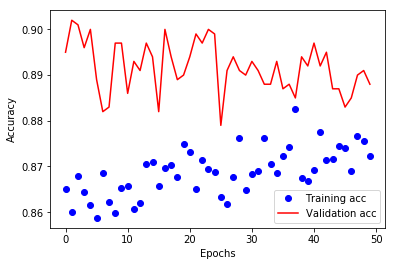

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()